# Algorithm: Decision Tree
Acknowledgement: Most of the code was referenced from Prof. Mafas Raheem's AML lab-5.1.
## Model Validation Strategy
Three models evaluated with two different datasets as described below.
### Standard data (without oversampling)
- Base,
- Grid-Search-CV,
- Random-Search-CV
### Oversampling data (class balancing)
- Base,
- Grid-Search-CV,
- Random-Search-CV

In [1]:
import warnings
from collections import Counter
from importlib import reload

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

import custom_libs.evaluation_helper as ev
import models.uci_heart_disease_dataset as uci

# Disabled warning.
# warnings.filterwarnings("ignore")

In [2]:
# Load the preprocessed dataset (299 records; with 14 features).
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

Data shape: (299, 14).


,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286.0,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229.0,0,2,129,1,2.6,2,2,7,1


### Model's Hyper-parameters & Cross-Vaidation Parameters

In [3]:
# Verbose variable for log inspection.
verbose = False

# Dictionary to hold model's hyperparameters.
parameters = dict()

# A minimal/effective set of hyperparameters were referenced from Prof. Mafas Raheem's Lab-5.1.
# Further hyperparameters can be referred below: https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# The function to measure the quality of a split. Default=gini.
parameters['criterion'] = ['entropy', 'gini', 'log_loss']
# The maximum depth of the tree. Default=None.
parameters['max_depth'] = [2, 3, 5, 10, 50]
# The number of features to consider when looking for the best split. Default=None.
parameters['max_features'] = ['log2', 'sqrt']
# The minimum number of samples required to split an internal node. Default=2.
parameters['min_samples_split'] = [2, 3, 50, 100]
# The minimum number of samples required to be at a leaf node. Default=1.
parameters['min_samples_leaf'] = [1, 5, 8, 10]

# A stratified K fold for cross validation strategy - values are assigned from the global class.
skfolds = StratifiedKFold(n_splits = ev.kfold_n_split,
                          shuffle = ev.kfold_shuffle,
                          random_state = ev.random_state)

# Reset accuracies for SVM
ev.accuracies = {}

### Base Model (Function)

In [ ]:
reload(ev)
# A function to build a base model.
def build_and_validate_base_model(x_set, y_set, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    # Train the model with training set.
    # Without the random-state, DT is producing different result despite the random-state in sample split for training-set.
    dc= DecisionTreeClassifier(random_state=ev.random_state)
    dc.fit(x_train, y_train)

    # Display the best hyperparameters used.
    print(f'Params         :{ dc.get_params()}.')

    # Do prediction with the trained model.
    y_pred = dc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve.
    ev.display_validation_report(y_test, y_pred, x_test, dc, test_name)

### Grid Search CV (Function)

In [ ]:
reload(ev)
# A function discover the model's best hyperparameters and perform cross-validation using GridSearchCV.
def build_and_validate_with_grid_search_cv(x_set, y_set, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    dt= DecisionTreeClassifier(random_state=ev.random_state)

    # Build Grid-search with parameters and stratified k fold strategy for cross-validation.
    grid_scv = GridSearchCV(dt, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    grid_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params          :{grid_scv.best_params_}.')
    print(f'Best score (*mean)   :{grid_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = grid_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve.
    ev.display_validation_report(y_test, y_pred, x_test, grid_scv, test_name)

### Random Search CV (Function)

In [ ]:
reload(ev)
# A function discover the model's best hyperparameters and perform cross-validation using RandomSearchCV.
def build_and_validate_with_random_search_cv(x_set, y_set, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    dt= DecisionTreeClassifier(random_state=ev.random_state)

    # Train and discover the model's best hyperparameters for optimal performance.
    rand_svc = RandomizedSearchCV(dt, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    rand_svc.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params :{rand_svc.best_params_}.')
    print(f'Best score  :{rand_svc.best_score_}.')

    # Predict using the trained model.
    y_pred = rand_svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, rand_svc, test_name)

## Evaluation with Standard Dataset (without oversampling)
`processed.cleveland-preprocessed` - standard dataset is the preprocessed data with 299 records and 14 columns.

### Data Preparation

In [ ]:
reload(ev)
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

print(f'Classes before split: {Counter(y)}.')

x_train, x_test, y_train, y_test = ev.scale_and_split(X, y)
print(f'Classes after split (train): {Counter(y_train)}.')
print(f'Classes after split (test): {Counter(y_test)}.')




Evaluation name: std-base.
Params         :{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 1, 'splitter': 'best'}.

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        32
           1       0.71      0.71      0.71        28

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.73      0.73      0.73        60

{'0': {'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75, 'support': 32.0}, '1': {'precision': 0.7142857142857143, 'recall': 0.7142857142857143, 'f1-score': 0.7142857142857143, 'support': 28.0}, 'accuracy': 0.7333333333333333, 'macro avg': {'precision': 0.7321428571428572, 'recall': 0.7321428571428572, 

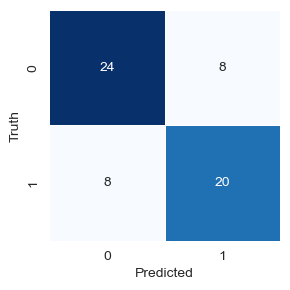

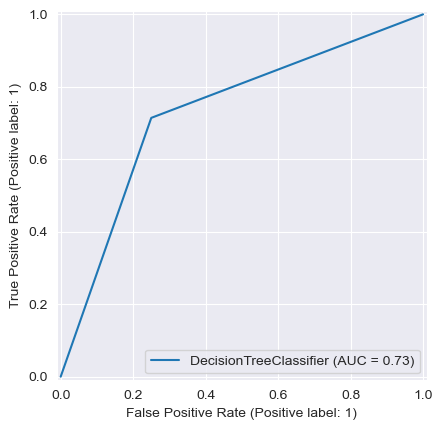

In [83]:
# Evaluation: Standard data with base model
reload(ev)
build_and_validate_base_model(X, y, ev.EvaluationType.std_base)

In [ ]:
# Evaluation: Standard data with Grid Search CV
build_and_validate_with_grid_search_cv(X, y, ev.EvaluationType.std_grid_search_cv)

In [ ]:
# Evaluation: Standard Random Search CV
build_and_validate_with_random_search_cv(X, y, ev.EvaluationType.std_random_search_cv)

In [ ]:
print(ev.accuracies)

## Evaluation with Oversampling Dataset (Class balancing)

### Data Preparation and Oversampling

In [ ]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Perform over-sampling with SMOTE
X_b, y_b = SMOTE().fit_resample(X, y)
print(f'Classes before oversampling :{Counter(data[uci.UCIHeartDiseaseData.target])}.')
print(f'Classes after oversampling  :{Counter(y_b)}.')

In [ ]:
# Before over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=data[uci.UCIHeartDiseaseData.target])

# After over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=y_b)

In [ ]:
# Evaluation: Over-sampled Base
build_and_validate_base_model(X_b, y_b, ev.EvaluationType.os_base)

In [ ]:
# Evaluation: Over-sampled Grid Search CV
build_and_validate_with_grid_search_cv(X_b, y_b, ev.EvaluationType.os_grid_search_cv)

In [ ]:
# Evaluation: Over-sampled Random Search CV
build_and_validate_with_random_search_cv(X_b, y_b, ev.EvaluationType.os_random_search_cv)

In [ ]:
print(ev.accuracies)

## Conclusion

In [ ]:
plt.bar(range(len(ev.accuracies)), list(ev.accuracies.values()), align='center')
plt.xticks(range(len(ev.accuracies)), list(ev.accuracies.keys()))

plt.show()

In [ ]:
### Register the highest in global
ev.global_accuracies['DT'] = 87